# Integrantes:  
Gaston Arida, Sebastian Ferreiro, Jeronimo Vernay

---

Nota: Los archivos originales fueron modificados para facilitar la lectura de los mismos. Aquí se encuentran
    en formato csv, y con pequeños cambios como nombres de columnas que no afectan a la información 
    concreta de los archivos originales.

---

# Leemos los archivos correspondientes al modelo relacional:

In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

BP_limpio = pd.read_csv("TablasModelo\\BP_limpio.csv")                          
EE_limpio01 = pd.read_csv("TablasModelo\\EE_limpio_final_usando2daopcion.csv")
Provincia = pd.read_csv("TablasModelo\\Provincia.csv")
Depto = pd.read_csv("TablasModelo\\Departamento_corregido.csv")
Poblacion = pd.read_csv("TablasModelo\\Padron_limpio_final.csv")


duckdb.register("EE", EE_limpio01)
duckdb.register("Poblacion", Poblacion)
duckdb.register("Departamento", Depto)
duckdb.register("Provincia", Provincia)  
duckdb.register("BP", BP_limpio)

---

# Consultas SQL en base al modelo relacional:

# 1)

In [5]:
consulta1 = """
WITH ee_por_departamento AS (
    SELECT 
        id_departamento,
        COUNT(DISTINCT CASE WHEN Jardin > 0 THEN Cueanexo END) AS jardines,
        COUNT(DISTINCT CASE WHEN Primario > 0 THEN Cueanexo END) AS primarias,
        COUNT(DISTINCT CASE WHEN Secundario > 0 THEN Cueanexo END) AS secundarios
    FROM EE
    GROUP BY id_departamento
),
poblacion_por_departamento AS (
    SELECT 
        id_departamento,
        SUM(CASE WHEN "Rango etario" = '3 a 5' THEN casos ELSE 0 END) AS poblacion_jardin,
        SUM(CASE WHEN "Rango etario" = '6 a 11' THEN casos ELSE 0 END) AS poblacion_primaria,
        SUM(CASE WHEN "Rango etario" = '12 a 18' THEN casos ELSE 0 END) AS poblacion_secundaria
    FROM Poblacion
    GROUP BY id_departamento
)

SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,

    COALESCE(ee.jardines, 0) AS jardines,
    COALESCE(pob.poblacion_jardin, 0) AS poblacion_jardin,

    COALESCE(ee.primarias, 0) AS primarias,
    COALESCE(pob.poblacion_primaria, 0) AS poblacion_primaria,

    COALESCE(ee.secundarios, 0) AS secundarios,
    COALESCE(pob.poblacion_secundaria, 0) AS poblacion_secundaria

FROM Depto dept
JOIN Provincia prov ON dept.id_provincia = prov.id
LEFT JOIN ee_por_departamento ee ON dept.id_departamento = ee.id_departamento
LEFT JOIN poblacion_por_departamento pob ON dept.id_departamento = pob.id_departamento

ORDER BY prov.nombre ASC, primarias DESC;
"""

resultado = duckdb.query(consulta1).to_df()
print(f"resultados 1: {resultado}")

resultados 1:         provincia        departamento  jardines  poblacion_jardin  primarias  \
0    Buenos Aires          LA MATANZA       333           87162.0        335   
1    Buenos Aires            LA PLATA       234           29260.0        201   
2    Buenos Aires     LOMAS DE ZAMORA       170           28806.0        179   
3    Buenos Aires  GENERAL PUEYRREDON       178           23100.0        168   
4    Buenos Aires             QUILMES       160           26975.0        145   
..            ...                 ...       ...               ...        ...   
523       Tucumán             TRANCAS        25            1163.0         25   
524       Tucumán      TAFI DEL VALLE        22            1010.0         24   
525       Tucumán            FAMAILLA        24            2322.0         23   
526       Tucumán      JUAN B ALBERDI        20            1586.0         19   
527       Tucumán            LA COCHA        17             992.0         18   

     poblacion_primaria  

---

# Graficos:

# 1)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18556\3235440714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Provincia', y='Cantidad', palette='plasma') #grafico


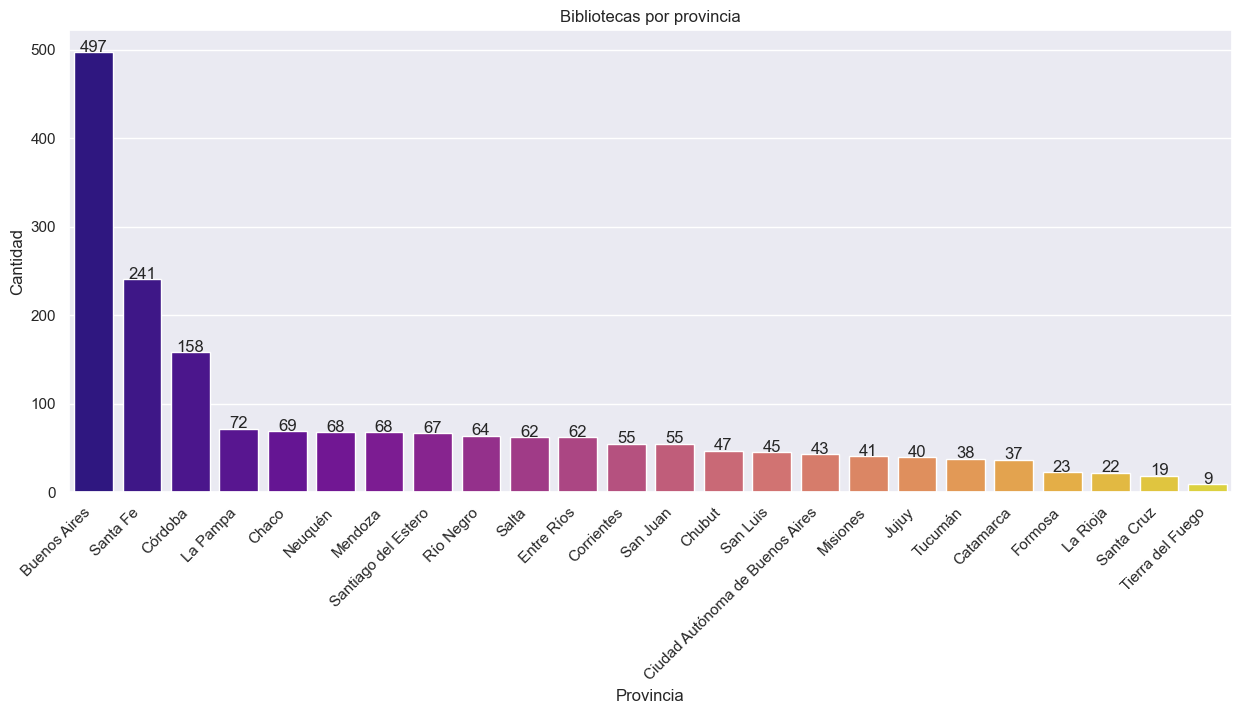

In [2]:
provincias = BP_limpio['provincia'].unique()

diccionario = {}
for provincia in provincias:
    diccionario[provincia] = len(BP_limpio.loc[BP_limpio['provincia'] == provincia])

# Creamos listas separadas para cada columna
provincias = list(diccionario.keys())
cantidad = list(diccionario.values())

# DataFrame con columnas
df = pd.DataFrame({
    'Provincia': provincias,
    'Cantidad': cantidad
})

df = df.sort_values(by='Cantidad', ascending=False) #ordeno las provincias por cantidad de bibliotecas de manera decreciente

sns.set(
    rc = {"figure.figsize": (15, 6)}
)  # Configuracion del ancho y largo del grafico para que se vea mejor

ax = sns.barplot(data=df, x='Provincia', y='Cantidad', palette='plasma') #grafico

plt.xticks(rotation=45, ha="right")  # Rotación y alineación del texto para que se puedan ver el nombre de cada una de las provincias

plt.title("Bibliotecas por provincia") # Titulo del grafico

for i, valor in enumerate(df["Cantidad"]):
    ax.text(i, valor + 0.5, str(valor), ha="center", fontsize=12)  # Usamos esto para poner el numero arriba de cada barra, asi es mas claro

plt.show()

#usamos la paleta plasma, ya que es amigable pora personas con daltonismo  (protanopia y deuteranopia)

# 3)

In [ ]:
con = duckdb.connect()

con.register('EE_limpio01', EE_limpio01)
con.register('BP_limpio', BP_limpio) 
gr = pd.read_csv(r"Graficos\\graf_3.csv") 

query = """
    SELECT Departamento, provincia, COUNT(Departamento) AS cantidad 
    FROM EE_limpio01 JOIN BP_limpio ON EE_limpio01."id_departamento" = BP_limpio."id_departamento"
    GROUP BY Departamento, provincia
    ORDER BY cantidad DESC
"""

resultado = con.execute(query).fetchdf()
resultado.to_csv('graf_3.csv', index=False)

#ordena por mediana de provincia, de manera descendiente
provincia_orden = (
    gr.groupby("provincia")["cantidad"]
    .median()
    .sort_values(ascending=False)
    .index
)

#tamaño del grafico
plt.figure(figsize=(16,10))

# --- Boxplot ---
boxplot = sns.boxplot(
    data=gr,
    x="provincia",
    y="cantidad",
    order=provincia_orden,
    palette="colorblind",
    width=0.6,
    showfliers=False,  # Ocultamos outliers (los mostramos con stripplot)
    linewidth=1.5
)

# --- Boxplot ---
sns.stripplot(
    data=gr,
    x="provincia",
    y="cantidad",
    order=provincia_orden,    # Agrupar por provincia
    palette="colorblind",     # Misma paleta que boxplot
    dodge=False,           
    alpha=1,
    size=5,
    linewidth=0.5,
    legend=False           # Oculta leyenda duplicada
)

# para la escala del eje y
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')


# --- Ajustes finales ---
plt.title("Distribución de EE por provincia", fontsize=14)
plt.xlabel("Provincia", fontsize=14)
plt.ylabel("Cantidad de EE", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=14)

#lineas para que se entiende a que provincia pertenece cada boxplot
for i in range(len(provincia_orden)):
    plt.axvline(i, color='gray', linewidth=0.3, linestyle='--')
    
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Graficos\\graf_3.csv'